# Simple model for NTK testing

In [5]:
# Uppsetning
using Flux
using Zygote
using MLDatasets
using LinearAlgebra
#  Bætti við ReverseDiff og ForwardDiff til að prufa
# using ReverseDiff  # has a tape-feature to save comp. time?
#using ForwardDiff  # Installed along with Zygote

using Plots
using LaTeXStrings

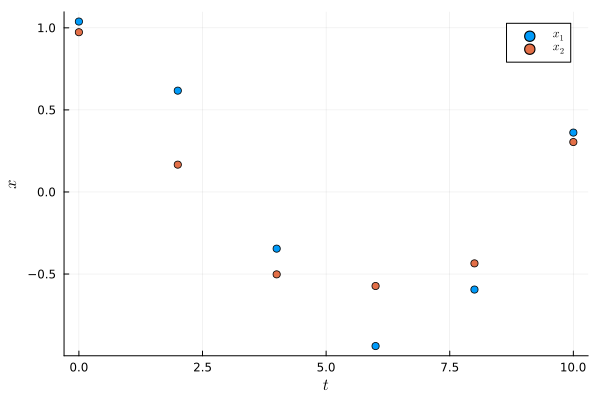

In [46]:
#
# create test data
#
tMax=10
Nt=Int(6)
tVec=collect((range(start=0.0,stop=tMax,length=Nt))')
ω=0.5
ϕ=0.0
x1Vec=cos.(ω*tVec .+ ϕ) +  0.1*rand(1,Nt)
δϕ=0.23
A=0.8
B=0.2
x2Vec=A*cos.(ω*tVec .+ ϕ .+ δϕ) + B*cos.(2*(ω*tVec .+ ϕ .+ δϕ)) +  0.1*rand(1,Nt)

scatter(tVec',x1Vec',label=L"$x_1$")
scatter!(tVec',x2Vec',label=L"$x_2$")
plot!(xlabel=L"$t$",ylabel=L"$x$")

In [7]:
#
#  Reproduce simple line fitting
#
actual(x) = 4x .+ 2
x_train, x_test = hcat(0:5...), hcat(6:10...)
y_train, y_test = actual.(x_train), actual.(x_test)

predict = Dense(1 => 1)
loss(model, x, y) = Flux.Losses.mse(model(x),y)
println("loss before =",loss(predict, x_train, y_train))

opt = Descent()
data = [(x_train, y_train)]
Nepoch=200
for epoch=1:Nepoch
    Flux.train!(loss, predict, data, opt)
end

println("loss after =",loss(predict, x_train, y_train))

loss before =

105.484764
loss after =0.0030741382


In [34]:
data1 = [(tVec, x1Vec)]
x1Vec

1×50 Matrix{Float64}:
 1.04634  1.04855  1.07641  0.999821  1.06426  …  0.969582  1.07777  0.885374

In [14]:
# Create simple model

Nhidd=80

model1 = Chain(  Dense(1 => Nhidd,sigmoid),Dense(Nhidd => 1)) # W_2[1x2](W_1[2x2]x[2,1]+b_1[2x1])+b_2[1]

#model1.layers[1].weight[1,1]
#model1.layers[1].bias[3,1]

# Define loss function
loss(yM, y) = Flux.Losses.mse(yM,y)

opt_state = Flux.setup(Adam(0.00003), model1)
opt_state = Flux.setup(Descent(0.0005), model1)
opt = Descent(0.0)
data1 = [(tVec, x1Vec)]
model1(tVec)
println("loss before=",loss(model1(tVec),x1Vec))

for epoch in 1:500000
    Flux.train!(model1, data1, opt_state) do m, x, y
        loss(m(x), y)
    end
end
println("loss after=",loss(model1(tVec),x1Vec))
#Flux.train!(loss, model1, data1, opt_state)


loss before=1.056877612882436


loss after=0.03768796984651048


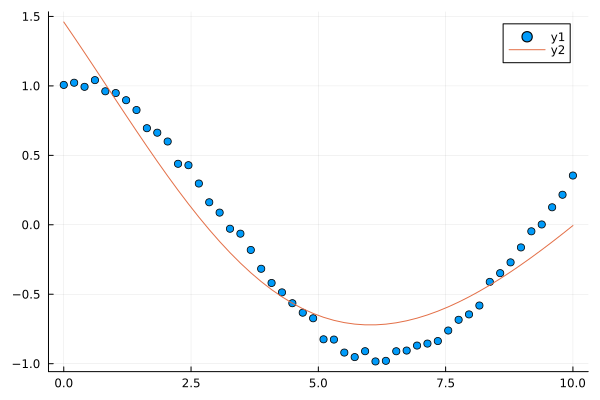

In [15]:
scatter(tVec',x1Vec')
plot!(tVec',model1(tVec)')

In [49]:
# reiknum Kernel

using IterTools

function df(K, model, x, y)
    df = []

    for i = 1:length(x)
        df[i] = -K * (y[i]-model(x[i]))
    end

    return df
end


function kernel(model, x)
    """
    This function computes the "Kernel" of a given NN
    """
   
   # training data
    n = length(x)
    K = zeros(n, n)         # Initialize empty Kernel
    
    # if typeof(model) == NN     # Svo að hægt sé að henda inn módeli sem er ekki af NN structi gerð
    #     model  = model.model
    # end

    # reikna gradient fyrir gefið x
    gs = xi-> Flux.gradient(() -> model([xi])[1],Flux.params(model)) # anonymous function
    all_grads = []
    
    # Collect numerical values
    for i in 1:n
        current_grad = []
        for j in 1:length(Flux.params(model))
            push!(current_grad, gs(x[i])[Flux.params(model)[j]]) # [:] til að fletja
        end
        current_grad = collect(Iterators.flatten(current_grad)) # flatten
        push!(all_grads, current_grad)
    end

    # Evaluate each K[i,j]
    for i = 1:n
        for j = 1:n
            K[i,j] = all_grads[i]'*all_grads[j] # ' means transposed
        end
    end

    return K
end


# function kernel_2(model, x)
   
#    # training data
#    n = length(x)
#    K = zeros(n, n)         # Initialize empty Kernel
   
#    # if typeof(model) == NN     # Svo að hægt sé að henda inn módeli sem er ekki af NN structi gerð
#    #     model  = model.model
#    # end

#    # reikna gradient fyrir gefið x
#    gs = xi-> Flux.gradient(() -> model([xi])[1],Flux.params(model)) # anonymous function
#    A = zeros(n,n)


#    for i in 1:n 
#     push!(A, gs(x[i]))
#    end
   

# #    # Collect numerical values
# #    for i in 1:n
# #        current_grad = []
# #        for j in 1:length(Flux.params(model))
# #            push!(current_grad, gs(x[i])[Flux.params(model)[j]]) # [:] til að fletja
# #        end
# #        current_grad = collect(Iterators.flatten(current_grad)) # flatten
# #        push!(all_grads, current_grad)
# #    end

# #    # Evaluate each K[i,j]
# #    for i = 1:n
# #        for j = 1:n
# #            K[i,j] = all_grads[i]'*all_grads[j] # ' means transposed
# #        end
# #    end

#    return K
# end

K = kernel(model1, tVec)
det(K)
eig = eigen(K).values
println(eig)

z = rand(6)

z'*K*z




[1.7804924361327076e-5, 0.0009638357203208571, 0.006086405800797014, 1.956459400377785, 19.356806855278613, 249.32988847621857]


487.9809284329664

In [34]:
Flux.gradient(() -> model1(x_train[1])[1],Flux.params(model1))
gs(x_train[1])[Flux.params(model1)[1]]

MethodError: MethodError: no method matching (::Dense{typeof(σ), Matrix{Float32}, Vector{Float32}})(::Int64)

Closest candidates are:
  (::Dense)(!Matched::AbstractVecOrMat)
   @ Flux C:\Users\trist\.julia\packages\Flux\jgpVj\src\layers\basic.jl:170
  (::Dense)(!Matched::AbstractArray)
   @ Flux C:\Users\trist\.julia\packages\Flux\jgpVj\src\layers\basic.jl:177


In [37]:
gs=Flux.gradient(() -> model1([1.0])[1],Flux.params(model1))

test = gs[Flux.params(model1)[1]]

80×1 Matrix{Float32}:
 -0.07990564
  0.07709908
  0.07142441
  0.15609455
  0.11087454
 -0.18562613
  0.094801255
  0.1256066
  0.12984504
  0.09060782
  ⋮
 -0.08837143
  0.12078882
 -0.122220315
  0.07595555
 -0.089463145
 -0.12809017
  0.21128128
 -0.12336082
 -0.13670489

In [43]:
# Athugum hvort það séu neikvæð eigingildi
eigval = eigen(K).values
#findall(x-> x<0, eigval)

LoadError: UndefVarError: `K` not defined

In [ ]:
function kernel(model, x, y)
    """
    This function computes the "Kernel" of a given NN
    """
    K = zeros(n, n)         # Initialize empty Kerne
    data = [(x, y)]
    n = length(x)

    # reikna gradient fyrir gefið x
    gs = xi-> Flux.gradient(() -> model(xi)[1],Flux.params(model)) # anonymous function
    all_grads = []
    
    # Collect numerical values
    for i in 1:n
        current_grad = []
        for j in 1:length(Flux.params(model))
            push!(current_grad, gs(x[i])[Flux.params(model)[j]]) # [:] til að fletja
        end
        current_grad = collect(Iterators.flatten(current_grad)) # flatten
        push!(all_grads, current_grad)
    end

    # Evaluate each K[i,j]
    for i = 1:n
        for j = 1:n
            K[i,j] = all_grads[i]'*all_grads[j] # ' means transposed
        end
    end

    return K
end

Nú prufum við þetta með NN.jl structinu okkar. <br>
Ég hef bara relevant hluta af structinu hér, en hann er á github ásamt öllu hinu.

In [6]:
### Aðferð 2 - með NN.jl

struct NN
    model::Any
    opt         # optimatzation method, so far only GD and ADAM
    lr          # learning rate
end

function load_MNIST()
    """
    Loading the MNIST dataset.
    10 classes of digits from 0 to 9,
    each with 28x28 pixel dimensions.
    X: Grayscale vector, Y: Correct label.
    """

    X_training, Y_training = MNIST(split = :train)[:]
    X_testing, Y_testing = MNIST(split = :test)[:]
    X_training = Flux.flatten(X_training)
    X_testing = Flux.flatten(X_testing)
    Y_training = Flux.onehotbatch(Y_training, 0:9)
    Y_testing = Flux.onehotbatch(Y_testing, 0:9)
    return X_training, Y_training, X_testing, Y_testing
end

function kernel(nn::NN, n=60000)
    """
    This function computes the "Kernel" of a given NN
    """
    x = load_MNIST()[1]     # training data
    K = zeros(n, n)         # Initialize empty Kernel
    model = nn.model
    

    # Calculate all gradients
    gs_raw = []
    for i = 1:n
        xi =  x[:,i] # current datapoint
        push!(gs_raw, Flux.gradient(() -> model(xi)[1],Flux.params(model)))
    end

    # Collect numerical values
    gs = []
    for i = 1:n
        gs_i = []
        for j = 1:length(Flux.params(model))
            push!(gs_i, gs_raw[i][Flux.params(model)[j]])
        end
        push!(gs, gs_i)
    end

    # Evaluate each K[i,j]
    for i = 1:n
        for j = 1:n
            K[i,j] = dot(gs[i], gs[j])
        end
    end

    return K
end

function model_3LS()
    """
    A 3-layer model using 60 nodes in the inner layers.
    Using the sigmoid activation function.
    """

    m_3LS = Chain(
        Dense(28*28, 60, sigmoid), # Input Layer -> Hidden Layer 1
        Dense(60, 60, sigmoid), # Hidden Layer 1 -> Hidden Layer 2
        Dense(60, 10, sigmoid), # Hidden Layer 2 -> Output Layer
        softmax      
    )
    return m_3LS
end

model_3LS (generic function with 1 method)

Athugið að við trainum módelið okkar ekki neitt hér

In [7]:
MODEL  = model_3LS()
OPT    = "ADAM"
LR     = 0.001

myNN = NN(MODEL, OPT, LR)

n = 10
K = kernel(myNN,n) # reiknar fyrir n datapunkta

10×10 Matrix{Float64}:
 0.0111556  0.0110418  0.0109027  …  0.0111046  0.0109061  0.0109173
 0.0110418  0.0112139  0.0109181     0.0110803  0.010892   0.010924
 0.0109027  0.0109181  0.0110516     0.0109909  0.0108542  0.0109238
 0.0109159  0.0109226  0.0108563     0.0109736  0.0108505  0.0108727
 0.0109495  0.0109814  0.0109183     0.011011   0.0109274  0.0109313
 0.0109337  0.0109531  0.0108756  …  0.0110022  0.0108372  0.0108986
 0.0109225  0.0108951  0.0108467     0.010939   0.0109282  0.0108572
 0.0111046  0.0110803  0.0109909     0.0112762  0.0109224  0.0109769
 0.0109061  0.010892   0.0108542     0.0109224  0.0109399  0.0108602
 0.0109173  0.010924   0.0109238     0.0109769  0.0108602  0.0110272

In [8]:
# Athugum hvort það séu neikvæð eigingildi
eigval = eigen(K).values
findall(x-> x<0, eigval)

Int64[]